Cell 1 — Install packages

In [1]:
# Install required packages (run once)
%pip install -q mne PyWavelets scikit-learn seaborn imbalanced-learn
%pip install -q azureml-core azure-ai-ml azure-identity

print("✅ Packages installed (if no errors above).")


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
✅ Packages installed (if no errors above).


Cell 2 — Load libraries + set seeds

In [2]:
# Basic utilities
import os
import random
import pickle

# Arrays
import numpy as np

# EEG processing
import mne
import pywt

# ML tools
from sklearn.decomposition import FastICA
from sklearn.metrics import confusion_matrix, roc_auc_score

# Balancing
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Helpers
from typing import Optional, Union, Sequence, Dict, Tuple, List

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger

try:
    tf.keras.utils.enable_interactive_logging()
except Exception:
    pass

# Set seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

print("✅ Imports done + seeds set.")


2026-01-23 18:10:35.168514: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-23 18:10:38.378045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769191839.387892    3167 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769191839.686937    3167 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769191842.358372    3167 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

✅ Imports done + seeds set.


Cell 3 — Azure download + load AD arrays + build labels (EXCLUDING last 5)

In [3]:
from azureml.core import Workspace, Datastore, Dataset

print("[STEP 1] Connecting to Azure ML workspace...")

subscription_id = "eccc04ba-d8b0-4f70-864a-b4a6753bfc72"
resource_group  = "somnasnest"
workspace_name  = "SomnasNest"
folder_path = "UI/2026-01-17_162622_UTC/Data Array/"

ws = Workspace.get(
    name=workspace_name,
    subscription_id=subscription_id,
    resource_group=resource_group
)
print("[STEP 1] Workspace connected ✅")

datastore = ws.get_default_datastore()
print("[STEP 1] Default datastore loaded ✅")

ds = Dataset.File.from_files(path=(datastore, folder_path))
print("[STEP 1] FileDataset created ✅")

local_dir = "./_ad_data_array"
os.makedirs(local_dir, exist_ok=True)

print(f"[STEP 1] Downloading data to: {local_dir} ...")
ds.download(target_path=local_dir, overwrite=True)
print("[STEP 1] Download complete ✅")

arrays = {}
print("[STEP 1] Loading .npy files...")
for root, _, files in os.walk(local_dir):
    for f in files:
        p = os.path.join(root, f)
        if f.lower().endswith(".npy"):
            arrays[f] = np.load(p, allow_pickle=False)

if "ad_negative.npy" not in arrays or "ad_positive.npy" not in arrays:
    raise FileNotFoundError("❌ Could not find ad_negative.npy and ad_positive.npy in downloaded folder.")

X_neg_full = arrays["ad_negative.npy"].astype(np.float32)  # (31,127,150000)
X_pos_full = arrays["ad_positive.npy"].astype(np.float32)  # (46,127,150000)

print("✅ Arrays loaded:")
print("  ad_negative.npy (full):", X_neg_full.shape)
print("  ad_positive.npy (full):", X_pos_full.shape)

# ✅ Modification #1: drop last 5 trials from BOTH arrays
if X_neg_full.shape[0] <= 5 or X_pos_full.shape[0] <= 5:
    raise ValueError("❌ One of the arrays has <= 5 trials; cannot drop last 5 safely.")

X_neg = X_neg_full[:-5]
X_pos = X_pos_full[:-31]

print("✅ After removing last 5 trials:")
print("  ad_negative.npy:", X_neg.shape)
print("  ad_positive.npy:", X_pos.shape)

# Labels
y_neg = np.zeros((X_neg.shape[0],), dtype=np.int32)
y_pos = np.ones((X_pos.shape[0],), dtype=np.int32)

X_all_trials = np.concatenate([X_neg, X_pos], axis=0)
y_all_trials = np.concatenate([y_neg, y_pos], axis=0)

print("[STEP 1] Combined dataset:")
print("  X_all_trials:", X_all_trials.shape)
print("  y_all_trials:", y_all_trials.shape)
print("  Class counts:", np.unique(y_all_trials, return_counts=True))


[STEP 1] Connecting to Azure ML workspace...
[STEP 1] Workspace connected ✅
[STEP 1] Default datastore loaded ✅
[STEP 1] FileDataset created ✅
[STEP 1] Downloading data to: ./_ad_data_array ...
{'infer_column_types': 'False', 'activity': 'download'}
{'infer_column_types': 'False', 'activity': 'download', 'activityApp': 'FileDataset'}
[STEP 1] Download complete ✅
[STEP 1] Loading .npy files...
✅ Arrays loaded:
  ad_negative.npy (full): (31, 127, 150000)
  ad_positive.npy (full): (46, 127, 150000)
✅ After removing last 5 trials:
  ad_negative.npy: (26, 127, 150000)
  ad_positive.npy: (15, 127, 150000)
[STEP 1] Combined dataset:
  X_all_trials: (41, 127, 150000)
  y_all_trials: (41,)
  Class counts: (array([0, 1], dtype=int32), array([26, 15]))


Class DeploymentTemplateOperations: This is an experimental class, and may change at any time. Please see https://aka.ms/azuremlexperimental for more information.
Overriding of current TracerProvider is not allowed
Overriding of current LoggerProvider is not allowed
Overriding of current MeterProvider is not allowed
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented
Attempting to instrument while already instrumented


* downsample to 500 Hz

In [4]:
import numpy as np
import mne

sfreq_in = 1000
sfreq_out = 500

# Cast to float64 for MNE, then back to float32 if you want
X_all_trials_ds = mne.filter.resample(
    X_all_trials.astype(np.float64, copy=False),
    down=sfreq_in // sfreq_out,   # 2
    npad="auto",
    axis=-1,
    verbose=True
).astype(np.float32, copy=False)

print("Before:", X_all_trials.shape, X_all_trials.dtype)
print("After: ", X_all_trials_ds.shape, X_all_trials_ds.dtype)


Before: (41, 127, 150000) float32
After:  (41, 127, 75000) float32


Cell 4 — Helper + leakage-safe preprocessing classes

In [5]:
def _names_from_index_mapping(n_channels, index_to_name):
    if index_to_name is None:
        return [f"EEG{i+1}" for i in range(n_channels)]
    keys = list(index_to_name.keys())
    is_zero_based = (0 in keys) and (1 not in keys)
    names = []
    for i in range(n_channels):
        key = i if is_zero_based else (i + 1)
        names.append(index_to_name.get(key, f"EEG{i+1}"))
    return names

def _make_raw(eeg, sfreq, ch_names, use_standard_1020=True):
    ch_types = ['eog' if str(n).upper().startswith("EOG") else 'eeg' for n in ch_names]
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw = mne.io.RawArray(eeg.astype(np.float32, copy=False), info, verbose=False)

    montage_applied = False
    if use_standard_1020:
        try:
            mont = mne.channels.make_standard_montage("standard_1020")
            raw.set_montage(mont, match_case=False, on_missing="ignore")
            montage_applied = True
        except Exception:
            montage_applied = False

    return raw, montage_applied

class WaveletICA:
    def __init__(self, wavelet="db4", level=3, n_components=10, random_state=42):
        self.wavelet = wavelet
        self.level = level
        self.n_components = n_components
        self.random_state = random_state
        self.ica_ = None
        self._n_ch = None

    def fit(self, X):
        C = X.shape[0]
        self._n_ch = C
        coeffs = pywt.wavedec(X, wavelet=self.wavelet, level=self.level, axis=1)
        A = coeffs[0]
        k = int(min(self.n_components, C))
        self.ica_ = FastICA(n_components=k, random_state=self.random_state)
        S = self.ica_.fit_transform(A.T)
        A_denoised = self.ica_.inverse_transform(S).T
        coeffs[0] = A_denoised
        _ = pywt.waverec(coeffs, wavelet=self.wavelet, axis=1)
        return self

    def transform(self, X):
        assert self.ica_ is not None, "WaveletICA not fitted yet."
        coeffs = pywt.wavedec(X, wavelet=self.wavelet, level=self.level, axis=1)
        A = coeffs[0]
        S = self.ica_.transform(A.T)
        A_denoised = self.ica_.inverse_transform(S).T
        coeffs[0] = A_denoised
        Y = pywt.waverec(coeffs, wavelet=self.wavelet, axis=1)

        if Y.shape[1] < X.shape[1]:
            Y = np.pad(Y, ((0, 0), (0, X.shape[1] - Y.shape[1])), mode="constant")
        elif Y.shape[1] > X.shape[1]:
            Y = Y[:, :X.shape[1]]

        return Y.astype(np.float32, copy=False)

class EEGPreprocessor:
    def __init__(
        self,
        *,
        index_to_name=None,
        use_standard_1020=True,
        resample_to=None,
        notch_freqs=50.0,
        highpass=0.05,
        bad_point_z=6.0,
        bad_channel_z=5.0,
        interpolate_bad_channels=False,
        car=True,
        use_wica=True,
        wica_components=10,
        wica_wavelet="db4",
        wica_level=3,
        wica_random_state=42
    ):
        self.index_to_name = index_to_name
        self.use_standard_1020 = use_standard_1020
        self.resample_to = resample_to
        self.notch_freqs = notch_freqs
        self.highpass = highpass
        self.bad_point_z = bad_point_z
        self.bad_channel_z = bad_channel_z
        self.interpolate_bad_channels = interpolate_bad_channels
        self.car = car
        self.use_wica = use_wica

        self._sfreq_out = None
        self._train_mu = None
        self._train_sd = None

        self._wica = WaveletICA(
            wavelet=wica_wavelet,
            level=wica_level,
            n_components=wica_components,
            random_state=wica_random_state
        )

    @property
    def sfreq_out(self):
        assert self._sfreq_out is not None, "Preprocessor not run yet."
        return float(self._sfreq_out)

    def _filter_and_reference(self, raw):
        if self.resample_to is not None and float(self.resample_to) != float(raw.info["sfreq"]):
            raw.resample(self.resample_to, npad="auto")
        self._sfreq_out = float(raw.info["sfreq"])

        if self.notch_freqs is not None:
            raw.notch_filter(freqs=self.notch_freqs, verbose=False)

        if self.highpass is not None:
            raw.filter(l_freq=self.highpass, h_freq=None, verbose=False)

        if self.car:
            raw.set_eeg_reference("average", projection=True)
            raw.apply_proj()

    def _repair_transients_with_train_stats(self, raw):
        X = raw.get_data()
        mu = self._train_mu
        sd = self._train_sd
        assert mu is not None and sd is not None, "Training stats not set."

        hi = mu + self.bad_point_z * sd
        lo = mu - self.bad_point_z * sd
        mask = (X > hi) | (X < lo)

        if np.any(mask):
            X_fixed = X.copy()
            t = np.arange(X.shape[1], dtype=float)
            for ch in range(X.shape[0]):
                m = mask[ch]
                if m.any():
                    good = ~m
                    if good.sum() >= 2:
                        X_fixed[ch, m] = np.interp(t[m], t[good], X_fixed[ch, good])
            raw._data = X_fixed

    def fit(self, X_train, sfreq):
        C = X_train.shape[0]
        ch_names = _names_from_index_mapping(C, self.index_to_name)

        raw_train, _ = _make_raw(X_train, sfreq, ch_names, self.use_standard_1020)
        self._filter_and_reference(raw_train)

        Xt = raw_train.get_data()
        self._train_mu = Xt.mean(axis=1, keepdims=True)
        self._train_sd = Xt.std(axis=1, keepdims=True) + 1e-12

        if self.use_wica:
            self._wica.fit(Xt)

        return self

    def transform(self, X, sfreq):
        C = X.shape[0]
        ch_names = _names_from_index_mapping(C, self.index_to_name)

        raw, _ = _make_raw(X, sfreq, ch_names, self.use_standard_1020)
        self._filter_and_reference(raw)
        self._repair_transients_with_train_stats(raw)

        Xf = raw.get_data()
        if self.use_wica:
            Xf = self._wica.transform(Xf)

        return Xf.astype(np.float32, copy=False), self.sfreq_out

    def fit_transform(self, X_train, sfreq):
        self.fit(X_train, sfreq)
        X_clean, fs_out = self.transform(X_train, sfreq)
        return X_clean, fs_out

print("✅ Preprocessing classes loaded.")


✅ Preprocessing classes loaded.


Cell 5 — Set sampling frequency + Preprocess all trials

In [6]:
print("[STEP 2] Starting preprocessing...")

fs = 500.0  # <-- CHANGE if needed
print(f"[STEP 2] Using fs={fs} Hz")

CHANNEL_MAP = None

pre = EEGPreprocessor(
    index_to_name=CHANNEL_MAP,
    use_standard_1020=True,
    resample_to=None,
    notch_freqs=[50.0, 100.0, 150.0],
    highpass=0.05,
    bad_point_z=6.0,
    bad_channel_z=5.0,
    interpolate_bad_channels=False,
    car=True,
    use_wica=True,
    wica_components=10,
    wica_wavelet="db4",
    wica_level=3,
    wica_random_state=42
)

max_calib_trials = min(10, X_all_trials.shape[0])
print(f"[STEP 2] Fitting preprocessor on first {max_calib_trials} trials...")

calib_trials = X_all_trials[:max_calib_trials]
X_calib = np.concatenate(calib_trials, axis=1).astype(np.float32, copy=False)

X_calib_clean, fs_out = pre.fit_transform(X_calib, fs)
print(f"[STEP 2] Preprocessor fitted ✅ | fs_out={fs_out} Hz")

data_clean = []
for i in range(X_all_trials.shape[0]):
    X_clean, _ = pre.transform(X_all_trials[i], fs)
    data_clean.append(X_clean.astype(np.float32, copy=False))
    if (i + 1) % 5 == 0 or (i + 1) == X_all_trials.shape[0]:
        print(f"[STEP 2] Preprocessed {i+1}/{X_all_trials.shape[0]} trials...")

data_clean = np.array(data_clean, dtype=np.float32)

print("[STEP 2] Done preprocessing ✅")
print("  data_clean shape:", data_clean.shape)
print("  labels shape    :", y_all_trials.shape)
print("  class counts    :", np.unique(y_all_trials, return_counts=True))


[STEP 2] Starting preprocessing...
[STEP 2] Using fs=500.0 Hz
[STEP 2] Fitting preprocessor on first 10 trials...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
[STEP 2] Preprocessor fitted ✅ | fs_out=500.0 Hz
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been app

Cell 6 — Augmentation

In [7]:
print("[STEP 3] Starting augmentation (segmentation)...")

def augment_data(trial_data, label, segment_size=100):
    segments = []
    labels = []
    n_segments = trial_data.shape[1] // segment_size
    for i in range(n_segments):
        seg = trial_data[:, i*segment_size:(i+1)*segment_size]
        segments.append(seg.astype(np.float32, copy=False))
        labels.append(int(label))
    return segments, labels

augmented = []
aug_targets = []

for idx, (trial, y) in enumerate(zip(data_clean, y_all_trials), start=1):
    segs, ys = augment_data(trial, y, segment_size=100)
    augmented.extend(segs)
    aug_targets.extend(ys)
    if idx % 5 == 0 or idx == len(data_clean):
        print(f"[STEP 3] Segmented {idx}/{len(data_clean)} trials...")

augmented = np.array(augmented, dtype=np.float32)   # (N,127,100)
aug_targets = np.array(aug_targets, dtype=np.int32)

print("[STEP 3] Augmentation done ✅")
print("  augmented shape:", augmented.shape)
print("  aug_targets shape:", aug_targets.shape)
print("  class counts:", np.unique(aug_targets, return_counts=True))


[STEP 3] Starting augmentation (segmentation)...
[STEP 3] Segmented 5/41 trials...
[STEP 3] Segmented 10/41 trials...
[STEP 3] Segmented 15/41 trials...
[STEP 3] Segmented 20/41 trials...
[STEP 3] Segmented 25/41 trials...
[STEP 3] Segmented 30/41 trials...
[STEP 3] Segmented 35/41 trials...
[STEP 3] Segmented 40/41 trials...
[STEP 3] Segmented 41/41 trials...
[STEP 3] Augmentation done ✅
  augmented shape: (61500, 127, 100)
  aug_targets shape: (61500,)
  class counts: (array([0, 1], dtype=int32), array([39000, 22500]))


Cell 7 — “Fair selection”

In [8]:
'''print("[STEP 4] Fair selection step...")

class_data = {0: [], 1: []}
for x, y in zip(augmented, aug_targets):
    class_data[int(y)].append(x)

max_per_class = 20000

selected_data = []
selected_targets = []

for cls in [0, 1]:
    picked = class_data[cls][:max_per_class]
    selected_data.extend(picked)
    selected_targets.extend([cls] * len(picked))
    print(f"[STEP 4] Picked {len(picked)} samples for class {cls}")

selected_data = np.array(selected_data, dtype=np.float32)   # (N,C,T)
selected_targets = np.array(selected_targets, dtype=np.int32)

print("[STEP 4] Selection done ✅")
print("  selected_data shape:", selected_data.shape)
print("  selected_targets shape:", selected_targets.shape)
print("  class counts:", np.unique(selected_targets, return_counts=True))
'''

'print("[STEP 4] Fair selection step...")\n\nclass_data = {0: [], 1: []}\nfor x, y in zip(augmented, aug_targets):\n    class_data[int(y)].append(x)\n\nmax_per_class = 20000\n\nselected_data = []\nselected_targets = []\n\nfor cls in [0, 1]:\n    picked = class_data[cls][:max_per_class]\n    selected_data.extend(picked)\n    selected_targets.extend([cls] * len(picked))\n    print(f"[STEP 4] Picked {len(picked)} samples for class {cls}")\n\nselected_data = np.array(selected_data, dtype=np.float32)   # (N,C,T)\nselected_targets = np.array(selected_targets, dtype=np.int32)\n\nprint("[STEP 4] Selection done ✅")\nprint("  selected_data shape:", selected_data.shape)\nprint("  selected_targets shape:", selected_targets.shape)\nprint("  class counts:", np.unique(selected_targets, return_counts=True))\n'

In [9]:
selected_data = augmented
selected_targets = aug_targets

Cell 8 — Reshape for EEGNet input

In [10]:
print("[STEP 5] Reshaping data for EEGNet...")

X_all = selected_data[..., np.newaxis].astype(np.float32, copy=False)  # (N,C,T,1)
y_all = selected_targets.astype(np.int32, copy=False)

print("[STEP 5] Done ✅")
print("  X_all shape:", X_all.shape)
print("  y_all shape:", y_all.shape)
print("  class counts:", np.unique(y_all, return_counts=True))


[STEP 5] Reshaping data for EEGNet...
[STEP 5] Done ✅
  X_all shape: (61500, 127, 100, 1)
  y_all shape: (61500,)
  class counts: (array([0, 1], dtype=int32), array([39000, 22500]))


Cell 9 — Train-only normalization on FULL DATA + save mean/std as PKL

In [11]:
print("[STEP 6] Computing normalization stats on FULL training data (final model)...")

eps = 1e-6
train_mean = np.mean(X_all, axis=(0, 2, 3), keepdims=True).astype(np.float32)
train_std  = np.std(X_all,  axis=(0, 2, 3), keepdims=True).astype(np.float32)
train_std  = np.maximum(train_std, eps)

X_norm = (X_all - train_mean) / train_std

print("[STEP 6] Normalization complete ✅")
print("  train_mean shape:", train_mean.shape)
print("  train_std  shape:", train_std.shape)
print("  X_norm shape     :", X_norm.shape)

# ✅ Modification #3: save mean/std as pkl files
with open("train_mean.pkl", "wb") as f:
    pickle.dump(train_mean, f)

with open("train_std.pkl", "wb") as f:
    pickle.dump(train_std, f)

print("✅ Saved normalization stats:")
print("  - train_mean.pkl")
print("  - train_std.pkl")


[STEP 6] Computing normalization stats on FULL training data (final model)...
[STEP 6] Normalization complete ✅
  train_mean shape: (1, 127, 1, 1)
  train_std  shape: (1, 127, 1, 1)
  X_norm shape     : (61500, 127, 100, 1)
✅ Saved normalization stats:
  - train_mean.pkl
  - train_std.pkl


Cell 10 — Class balancing using SMOTE

In [12]:
print("[STEP 7] Applying SMOTE on FULL normalized training data (separate step)...")

input_shape = X_norm.shape[1:]  # (C,T,1)
X_2d = X_norm.reshape(X_norm.shape[0], -1)

unique_before, counts_before = np.unique(y_all, return_counts=True)
minority_n = int(np.min(counts_before))

print("[STEP 7] Class counts before SMOTE:", dict(zip(unique_before, counts_before)))

if minority_n >= 2:
    k_neighbors = max(1, min(5, minority_n - 1))
    smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
    X_bal_2d, y_bal = smote.fit_resample(X_2d, y_all)
    print(f"[STEP 7] SMOTE applied ✅ (k={k_neighbors})")
else:
    ros = RandomOverSampler(random_state=42)
    X_bal_2d, y_bal = ros.fit_resample(X_2d, y_all)
    print("[STEP 7] SMOTE not possible → used RandomOverSampler ⚠️")

X_bal = X_bal_2d.reshape(-1, *input_shape).astype(np.float32)
y_bal = y_bal.astype(np.float32)

unique_after, counts_after = np.unique(y_bal.astype(int), return_counts=True)
print("[STEP 7] Balanced shapes:")
print("  X_bal:", X_bal.shape)
print("  y_bal:", y_bal.shape)
print("[STEP 7] Class counts after balancing:", dict(zip(unique_after, counts_after)))


[STEP 7] Applying SMOTE on FULL normalized training data (separate step)...
[STEP 7] Class counts before SMOTE: {np.int32(0): np.int64(39000), np.int32(1): np.int64(22500)}
[STEP 7] SMOTE applied ✅ (k=5)
[STEP 7] Balanced shapes:
  X_bal: (78000, 127, 100, 1)
  y_bal: (78000,)
[STEP 7] Class counts after balancing: {np.int64(0): np.int64(39000), np.int64(1): np.int64(39000)}


Cell 11 — EEGNet model

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Input, SeparableConv2D, DepthwiseConv2D, BatchNormalization, Activation,
    AveragePooling2D, Dropout, Dense, Add, Lambda, Reshape,
    LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

def SpatialAttention(x):
    """Spatial attention over EEG electrodes (channel dimension)."""
    attention = tf.keras.layers.GlobalAveragePooling2D()(x)          # (batch, channels)
    attention = Dense(64, activation='relu')(attention)
    attention = Dense(x.shape[1], activation='sigmoid')(attention)   # (batch, channels)
    # ✅ fix: use a Keras layer (not tf.reshape) so it works with KerasTensors
    attention = Reshape((x.shape[1], 1, 1))(attention)               # (batch, channels, 1, 1)
    return tf.keras.layers.Multiply()([x, attention])

def TransformerBlock(x, num_heads=4, key_dim=64, ff_dim=128, dropout_rate=0.1):
    """Transformer block with MHSA + FFN."""
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    attn_output = Add()([x, attn_output])
    attn_output = LayerNormalization()(attn_output)

    ff_output = Dense(ff_dim, activation='relu')(attn_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    ff_output = Dense(x.shape[-1])(ff_output)
    x = Add()([attn_output, ff_output])
    x = LayerNormalization()(x)
    return x

def EEGNet_SpatialTransformer(input_shape=(127, 100, 1), dropout_rate=0.5, num_heads=4, ff_dim=128):
    inputs = Input(shape=input_shape)

    # Depthwise Separable Convolution with Shared Filters
    x = SeparableConv2D(32, (1, 5), padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Spatial Attention Mechanism
    x = SpatialAttention(x)

    # Depthwise Convolution (Spatial Filtering per EEG Channel)
    # ✅ keep architecture same, but make electrode count match input_shape[0]
    x = DepthwiseConv2D((input_shape[0], 1), use_bias=False, depth_multiplier=2, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual Connection (Skip Connection) — keep as you wrote, but adapt to input channels
    residual = Lambda(lambda y: y[:, :, :, :32])(inputs)
    residual = BatchNormalization()(residual)
    x = Add()([x, residual])
    x = BatchNormalization()(x)

    # First Average Pooling Layer
    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropout_rate)(x)

    # Depthwise Separable Convolution (Extract Temporal-Spatial Features)
    x = SeparableConv2D(64, (1, 3), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second Average Pooling Layer
    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropout_rate)(x)

    # Transformer Block (Long-Term Dependencies)
    x_shape = K.int_shape(x)
    x = Reshape((x_shape[1], x_shape[2] * x_shape[3]))(x)
    x = TransformerBlock(x, num_heads=num_heads, key_dim=64, ff_dim=ff_dim, dropout_rate=0.1)

    # Global Average Pooling
    x = GlobalAveragePooling1D()(x)
    x = BatchNormalization()(x)

    # Fully Connected Layers
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs, name="EEGNet_SpatialTransformer")
    return model

# Instantiate + compile
model = EEGNet_SpatialTransformer(input_shape=(127, 100, 1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy', threshold=0.5)]
)


2026-01-23 18:18:30.020213: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Cell 12 — Train FINAL generalized model

[STEP 8] Preparing train/validation split (80/20)...
[STEP 8] Split complete ✅
  X_train: (62400, 127, 100, 1)  y_train: (62400,)
  X_val  : (15600, 127, 100, 1)  y_val  : (15600,)
[STEP 8] Class counts (train): {np.int64(0): np.int64(31200), np.int64(1): np.int64(31200)}
[STEP 8] Class counts (val)  : {np.int64(0): np.int64(7800), np.int64(1): np.int64(7800)}
[STEP 8] Building EEGNet_SpatialTransformer model...
[STEP 8] Model built ✅


Model: "EEGNet_SpatialTransformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 127, 100,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 127, 100,  │         37 │ input_layer_1[0]… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 127, 100,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 127, 100,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ activation_3[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      2,112 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 127)       │      8,255 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 127, 1, 1) │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 127, 100,  │          0 │ activation_3[0][… │
│ (Multiply)          │ 32)               │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d_1  │ (None, 1, 100,    │      8,128 │ multiply_1[0][0]  │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1, 100,    │        256 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 127, 100,  │          0 │ input_layer_1[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 1, 100,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 127, 100,  │          4 │ lambda_1[0][0]    │
│ (BatchNormalizatio… │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 127, 100,  │          0 │ activation_4[0][… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 127, 100,  │        256 │ add_3[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 127, 25,   │          0 │ batch_normalizat… │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 127, 25,   │          0 │ average_pooling2

 Total params: 569,897 (2.17 MB)

 Trainable params: 568,423 (2.17 MB)

 Non-trainable params: 1,474 (5.76 KB)

[STEP 8] Setting callbacks (monitoring val_loss)...
[STEP 8] Starting training on TRAIN set + validating on VAL set...
Epoch 1/200
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 1213s 309ms/step - accuracy: 0.8613 - loss: 0.3020 - val_accuracy: 0.9899 - val_loss: 0.0306 - learning_rate: 0.0010
Epoch 2/200
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 1215s 311ms/step - accuracy: 0.9868 - loss: 0.0413 - val_accuracy: 0.9922 - val_loss: 0.0193 - learning_rate: 0.0010
Epoch 3/200
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 1218s 312ms/step - accuracy: 0.9925 - loss: 0.0230 - val_accuracy: 0.9976 - val_loss: 0.0073 - learning_rate: 0.0010
Epoch 4/200
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 1212s 311ms/step - accuracy: 0.9954 - loss: 0.0155 - val_accuracy: 0.9919 - val_loss: 0.0205 - learning_rate: 0.0010
Epoch 5/200
3900/3900 ━━━━━━━━━━━━━━━━━━━━ 1216s 312ms/step - accuracy: 0.9962 - loss: 0.0115 - val_accuracy: 0.9881 - val_loss: 0.0417 - learning_rate: 0.0010
Epoch 

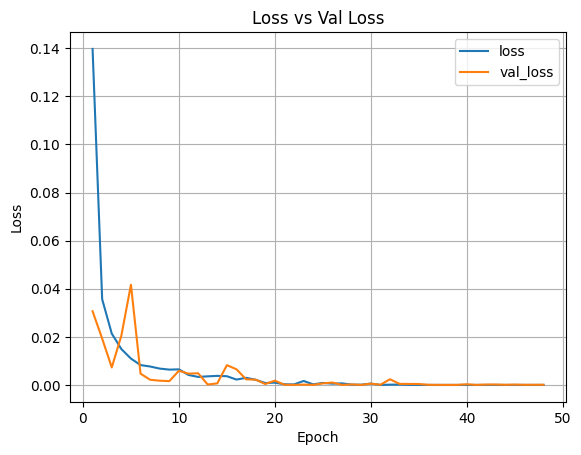

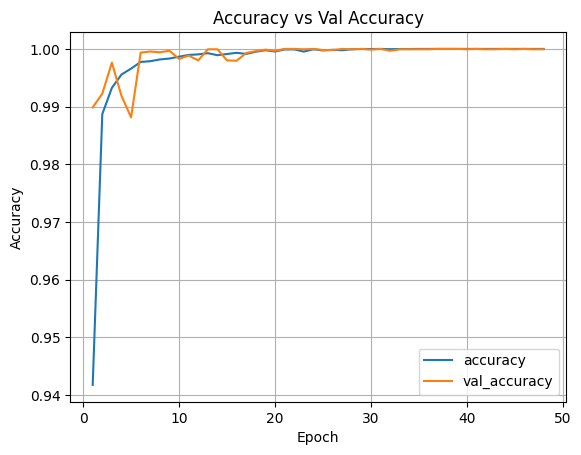

[STEP 9] Plots generated ✅


In [14]:
# Cell 12 — Train FINAL generalized model (with 80/20 train/val split + val_loss early stopping + plots)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger

print("[STEP 8] Preparing train/validation split (80/20)...")

# ✅ 80/20 split with stratification to preserve class balance in val set
X_train, X_val, y_train, y_val = train_test_split(
    X_bal, y_bal,
    test_size=0.20,
    random_state=42,
    stratify=y_bal.astype(int)
)

print("[STEP 8] Split complete ✅")
print("  X_train:", X_train.shape, " y_train:", y_train.shape)
print("  X_val  :", X_val.shape,   " y_val  :", y_val.shape)

# Track class distribution in each split
u_tr, c_tr = np.unique(y_train.astype(int), return_counts=True)
u_va, c_va = np.unique(y_val.astype(int), return_counts=True)
print("[STEP 8] Class counts (train):", dict(zip(u_tr, c_tr)))
print("[STEP 8] Class counts (val)  :", dict(zip(u_va, c_va)))

print("[STEP 8] Building EEGNet_SpatialTransformer model...")
model = EEGNet_SpatialTransformer(input_shape=X_train.shape[1:], dropout_rate=0.5, num_heads=4, ff_dim=128)

# compile exactly as before (binary)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy", threshold=0.5)]
)

print("[STEP 8] Model built ✅")
model.summary()

print("[STEP 8] Setting callbacks (monitoring val_loss)...")

# ✅ Early stopping based on validation loss
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# ✅ LR scheduler based on validation loss
lr_plateau = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

csv_logger = CSVLogger("ad_final_train_log.csv", append=False)
callbacks = [early_stop, lr_plateau, csv_logger]

print("[STEP 8] Starting training on TRAIN set + validating on VAL set...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=16,
    shuffle=True,
    verbose=1,
    callbacks=callbacks
)

print("[STEP 8] Training complete ✅")

# ✅ Save final model
final_model_path = "ad_eegformer-v1.keras"
model.save(final_model_path)

print("✅ Final model saved:", final_model_path)
print("✅ Training log saved: ad_final_train_log.csv")
print("✅ Normalization files saved: train_mean.pkl, train_std.pkl")

# -----------------------------
# Plot metrics per epoch
# -----------------------------
print("[STEP 9] Plotting training curves...")

hist = history.history
epochs_ran = range(1, len(hist["loss"]) + 1)

# Loss plot
plt.figure()
plt.plot(epochs_ran, hist["loss"], label="loss")
plt.plot(epochs_ran, hist["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Val Loss")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy plot (handle key name safely)
acc_key = "accuracy" if "accuracy" in hist else "binary_accuracy"
val_acc_key = "val_accuracy" if "val_accuracy" in hist else "val_binary_accuracy"

plt.figure()
plt.plot(epochs_ran, hist[acc_key], label=acc_key)
plt.plot(epochs_ran, hist[val_acc_key], label=val_acc_key)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Val Accuracy")
plt.legend()
plt.grid(True)
plt.show()

print("[STEP 9] Plots generated ✅")
